In [1]:
import IPython
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from kapre import (
    STFT,
    ApplyFilterbank,
    ConcatenateFrequencyMap,
    InverseSTFT,
    Magnitude,
    MagnitudeToDecibel,
    Phase,
)
from kapre.composed import get_log_frequency_spectrogram_layer, get_melspectrogram_layer
from tensorflow import keras
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    GlobalAveragePooling2D,
    ReLU,
    Softmax,
)
from tensorflow.keras.models import Sequential
from tqdm import tqdm

from lib.float2d_to_rgb_layer import Float2DToFloatRGB, Float2DToRGB
from lib.melspectrogram_layer import MelSpectrogram
from lib.power_to_db_layer import PowerToDb
from lib.utils import float2d_to_rgb, save_keras_model
from src.config import c
from src.services import get_msg_provider, get_wave_provider

In [2]:
# IPython.core.pylabtools.figsize(5, 5)

In [3]:
# keras.mixed_precision.set_global_policy("mixed_float16")
# tf.config.optimizer.set_jit(True)

In [4]:
N_MELS = 256
N_TIMESTEPS = 256
POWER = 3
N_WAVES = 1024

In [5]:
wave_p = get_wave_provider(c)
msg_p = get_msg_provider(c)

waves = []

df = pd.read_pickle("/app/_work/dataset-C.pickle")
fragments = df[["filename", "_from_s", "_to_s"]].sample(n=N_WAVES).to_dict("list")

for f, s, e in tqdm(
    zip(fragments["filename"], fragments["_from_s"], fragments["_to_s"]),
    total=len(fragments["filename"]),
):
    waves.append(wave_p.get_audio_fragment(f, [s, e]))

waves = np.array(waves)

100%|██████████| 1024/1024 [00:02<00:00, 486.16it/s]


In [6]:
waves = np.repeat(waves, 1, axis=0)
# np.random.shuffle(waves)

In [7]:
waves = waves[..., np.newaxis]

In [8]:
waves.shape

(1024, 160000, 1)

In [9]:
ipd.Audio(data=waves[10][:, 0], rate=c["AUDIO_SR"])

In [10]:
hop_length = waves[0].shape[0] // (N_TIMESTEPS - 1)

In [11]:
keras.backend.clear_session()

In [12]:
class Pow(keras.layers.Layer):
    def __init__(
        self,
        power=2.0,
        **kwargs,
    ):
        super(Pow, self).__init__(**kwargs)
        self._power = power

    def call(self, inputs):
        return keras.backend.square(inputs)

    def get_config(self):

        config = {"power": self._power}

In [ ]:
i = x = keras.layers.Input(shape=waves.shape[1:], dtype=waves.dtype)

x = STFT(
    input_shape=waves.shape[1:],
    n_fft=c["MSG_N_FFT"],
    hop_length=hop_length,
    pad_begin=False,
    pad_end=True,
    input_data_format="channels_last",
    output_data_format="channels_last",
)(x)

x = Magnitude()(x)

x = ApplyFilterbank(
    type="mel",
    filterbank_kwargs={
        "sample_rate": c["AUDIO_SR"],
        "n_freq": c["MSG_N_FFT"] // 2 + 1,
        "n_mels": N_MELS,
        "f_min": c["MSG_FREQ_RANGE"][0],
        "f_max": c["MSG_FREQ_RANGE"][1],
    },
    data_format="channels_last",
)(x)

x = Pow(3)(x)

x = MagnitudeToDecibel()(x)

x = keras.layers.Reshape((256, 256))(x)
x = Float2DToRGB()(x)

m = keras.models.Model(inputs=[i], outputs=[x])

In [20]:
save_keras_model(m, "model.png", dpi=75, rankdir="LR")

In [21]:
print(f"{waves.size * waves.itemsize / 2**30:.2f} GB")

0.31 GB


In [22]:
for i in range(1):
    msgs_f = m.predict(waves, verbose=1, batch_size=64)

16/16 [==============================] - 2s 20ms/step


In [23]:
msgs_f.shape

(1024, 256, 256, 3)

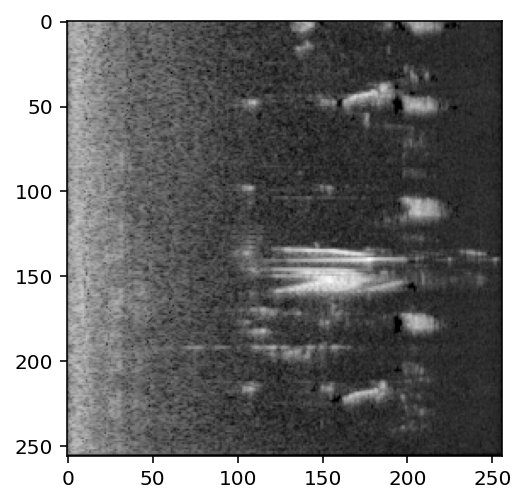

In [24]:
plt.imshow(msgs_f[0])

In [25]:
# %timeit float2d_to_rgb(msg_p.msg(waves[0][:, 0], N_MELS, N_TIMESTEPS, POWER))

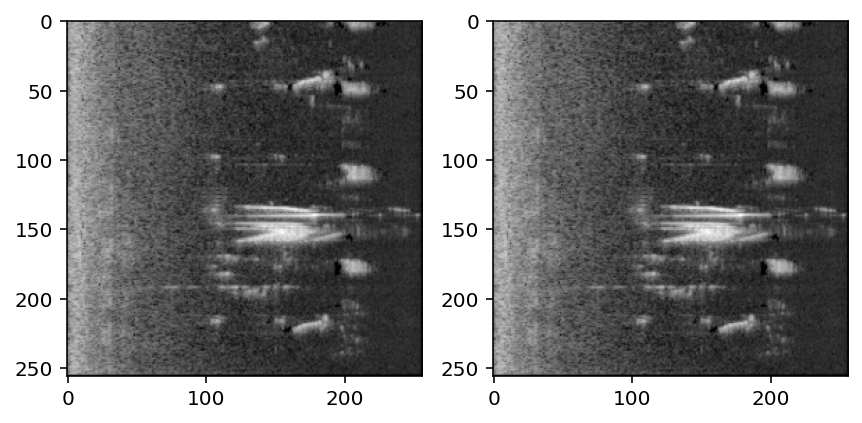

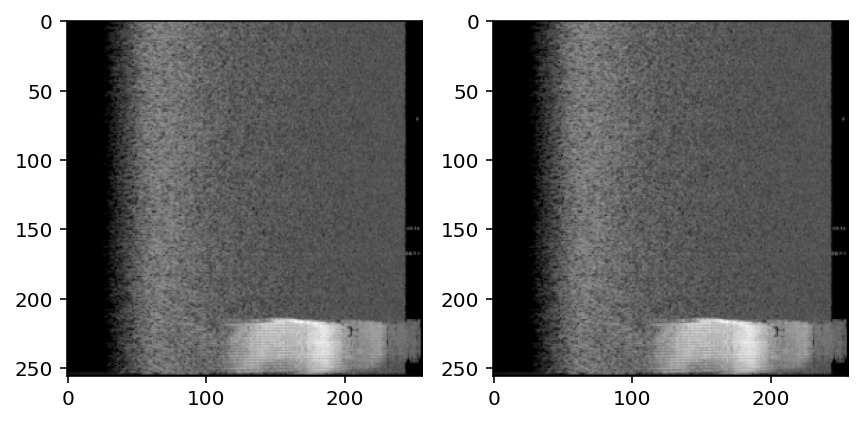

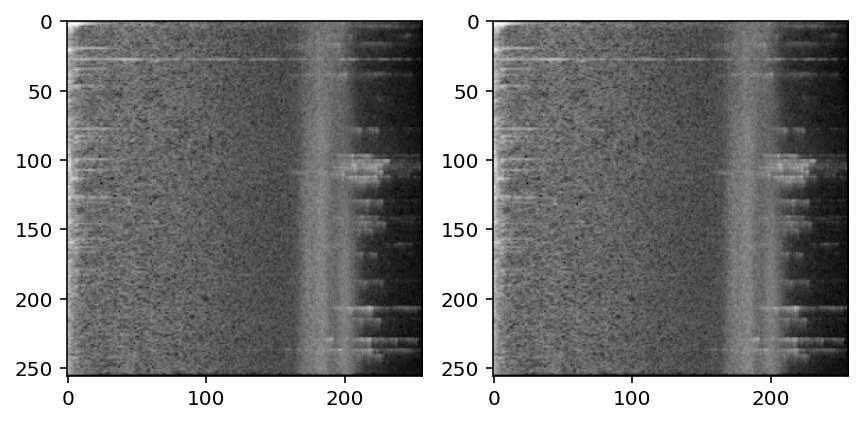

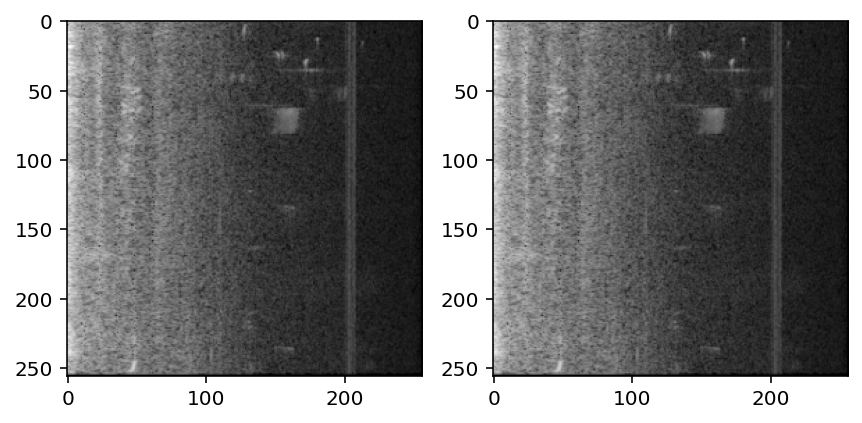

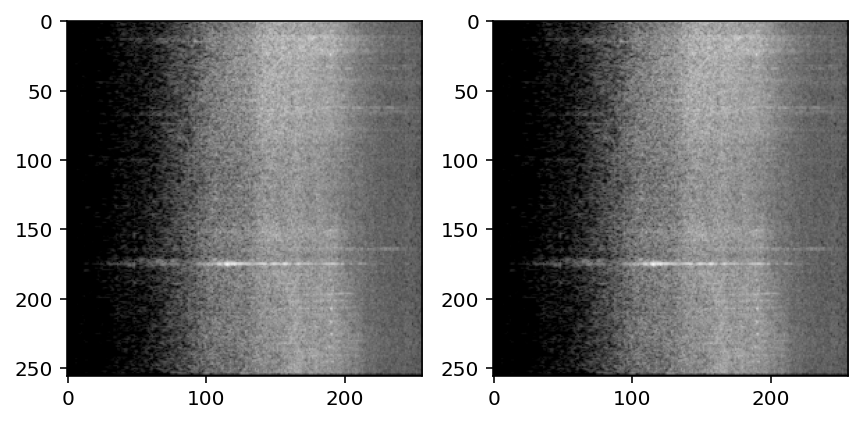

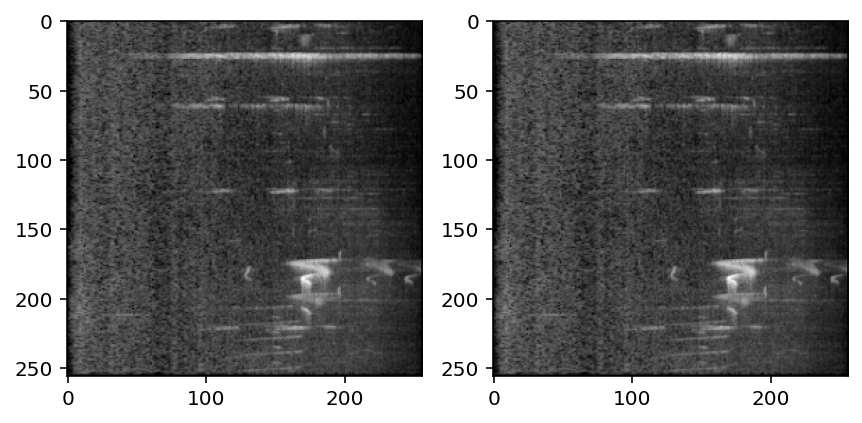

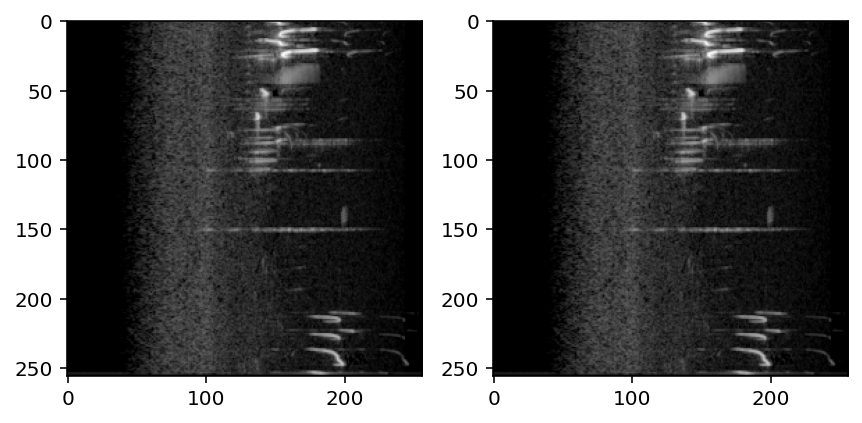

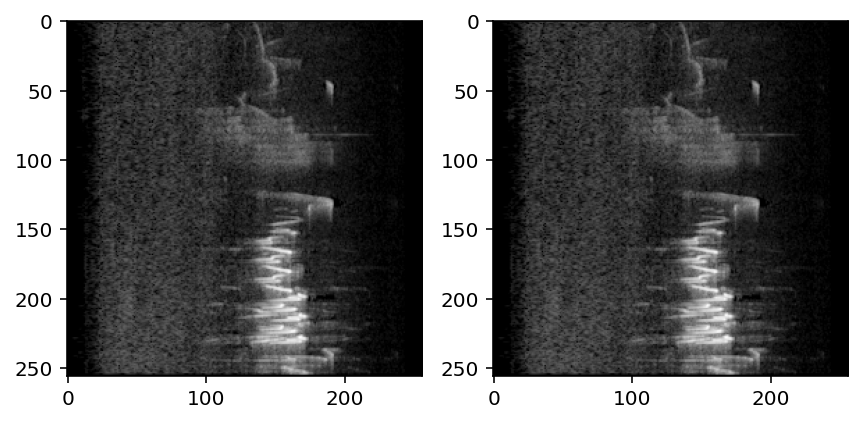

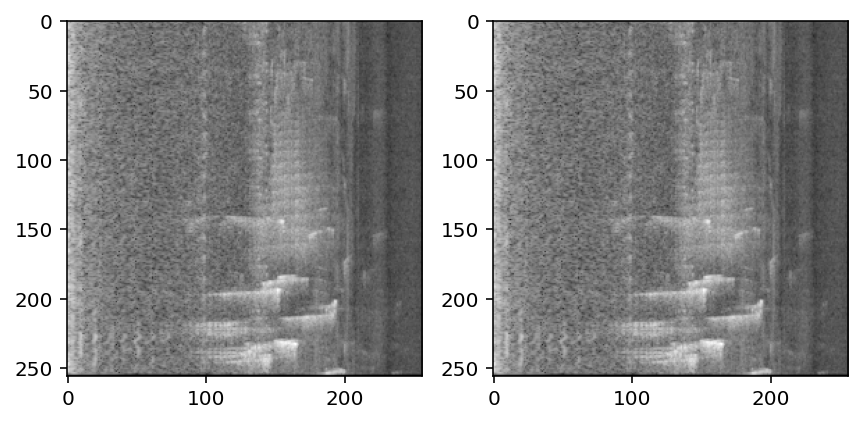

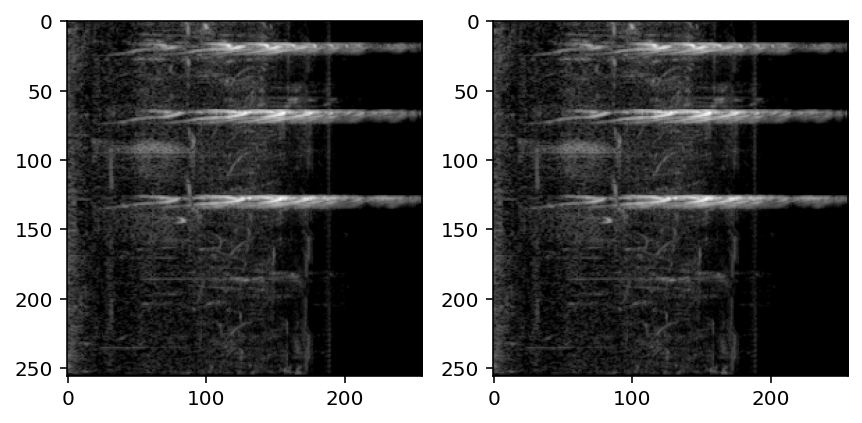

In [26]:
for i in range(len(msgs_f[:10])):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))
    a = msgs_f[i]
    # b = float2d_to_rgb(msg_p.msg(waves[i][:, 0], N_MELS, N_TIMESTEPS, POWER).T)
    b = float2d_to_rgb(msgs_f[i][:, :, 0].astype(np.float32))
    ax1.imshow(a)
    ax2.imshow(b)
    fig.show()